In [1]:
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils import visualizations as vis
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import dynamical_systems_sensitivity as sens

## Generate data

In [2]:
sys = Lorenz63

integrator = 'rk4'

# simulation options
sim_time = 50 # total simulation time
sim_dt = 1e-2 # simulation time step

# system parameters
INIT_beta_list = [8/3]
INIT_rho_list = [30,35,40,45,50]
INIT_sigma_list = [10]
eParam = Lorenz63.get_eParamVar()
param_mesh = [None]*3
param_mesh[eParam.beta] = INIT_beta_list
param_mesh[eParam.rho] = INIT_rho_list
param_mesh[eParam.sigma] = INIT_sigma_list
input_vars = ["x","y","z"]
param_vars = ["rho"]

param_list = pp.make_param_mesh(param_mesh)
train_idx_list = [0,2,4] # indices of regimes used for training
val_idx_list = [1,3] # indices of regimes used for validation

# discard transient time from the data
transient_time = 20

# network time step
network_dt = 1e-2

# washout time is used to warm up the ESN and 
# eliminate effects of initial reservoir state
washout_time = 4

# length of training time series
train_time = 10
# length of validation time series
validation_time = 100

In [3]:
loop_names=['train','val']
loop_times = [train_time, validation_time]

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

# valid_point_idxs = []
for p_idx, p in enumerate(param_list):
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in sys.get_eParamVar()])
    print("Regime:", regime_str)
    params = {}
    for param in sys.get_eParamVar():
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,params,sim_time,sim_dt,random_seed=0,integrator=integrator)

    regime_data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=input_vars,
                        param_vars=param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]
        
# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

# enums for referencing
eSys = my_sys.get_eVar()

Regime: beta = 2.667 rho = 30.000 sigma = 10.000
Regime: beta = 2.667 rho = 35.000 sigma = 10.000
Regime: beta = 2.667 rho = 40.000 sigma = 10.000
Regime: beta = 2.667 rho = 45.000 sigma = 10.000
Regime: beta = 2.667 rho = 50.000 sigma = 10.000


### Plot data

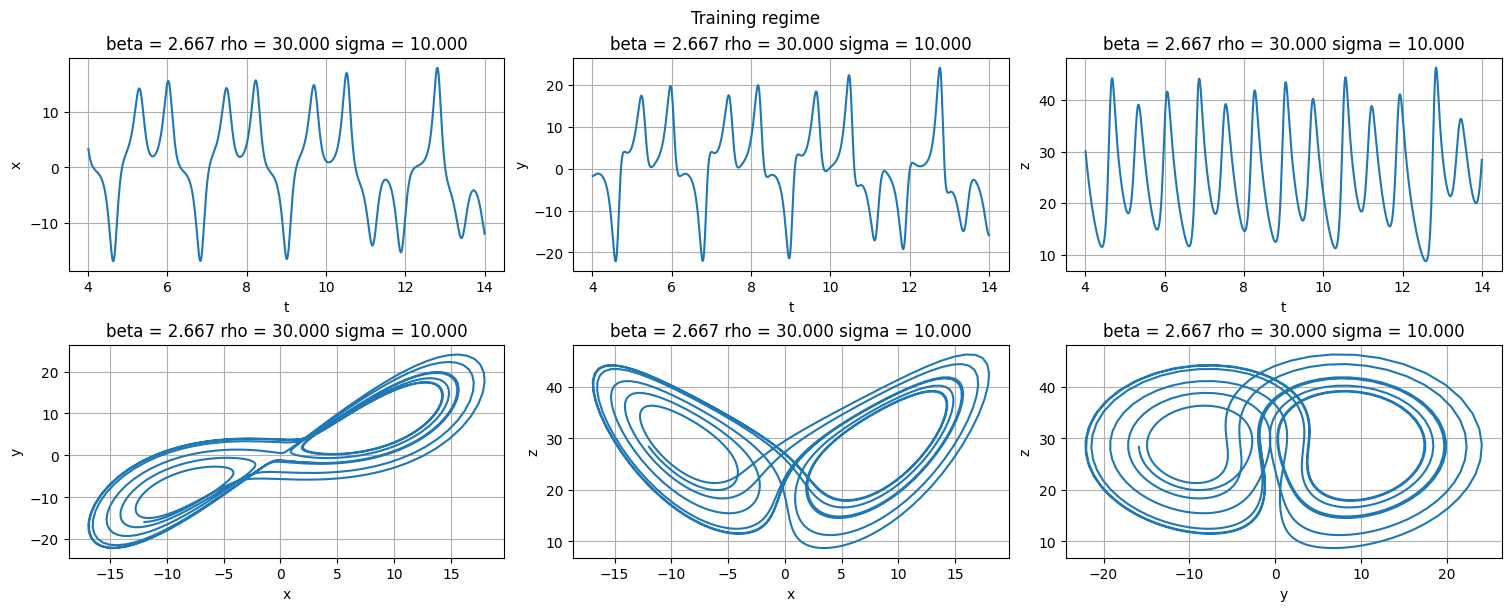

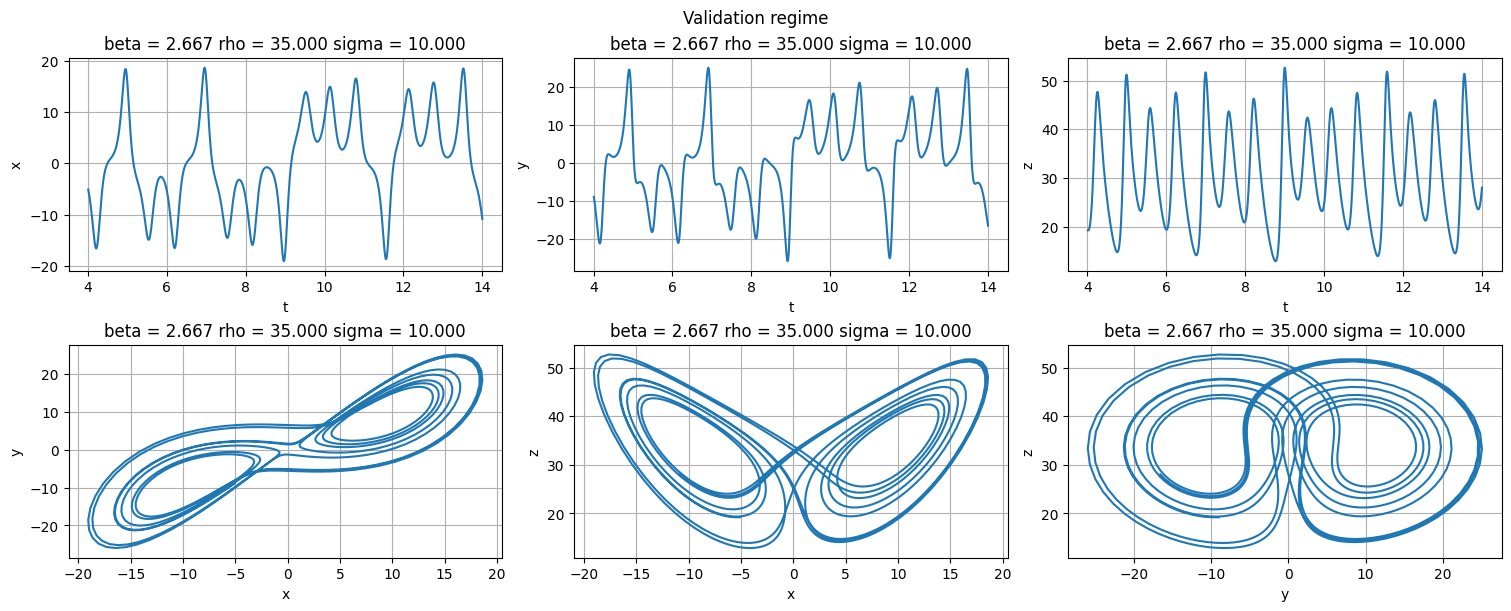

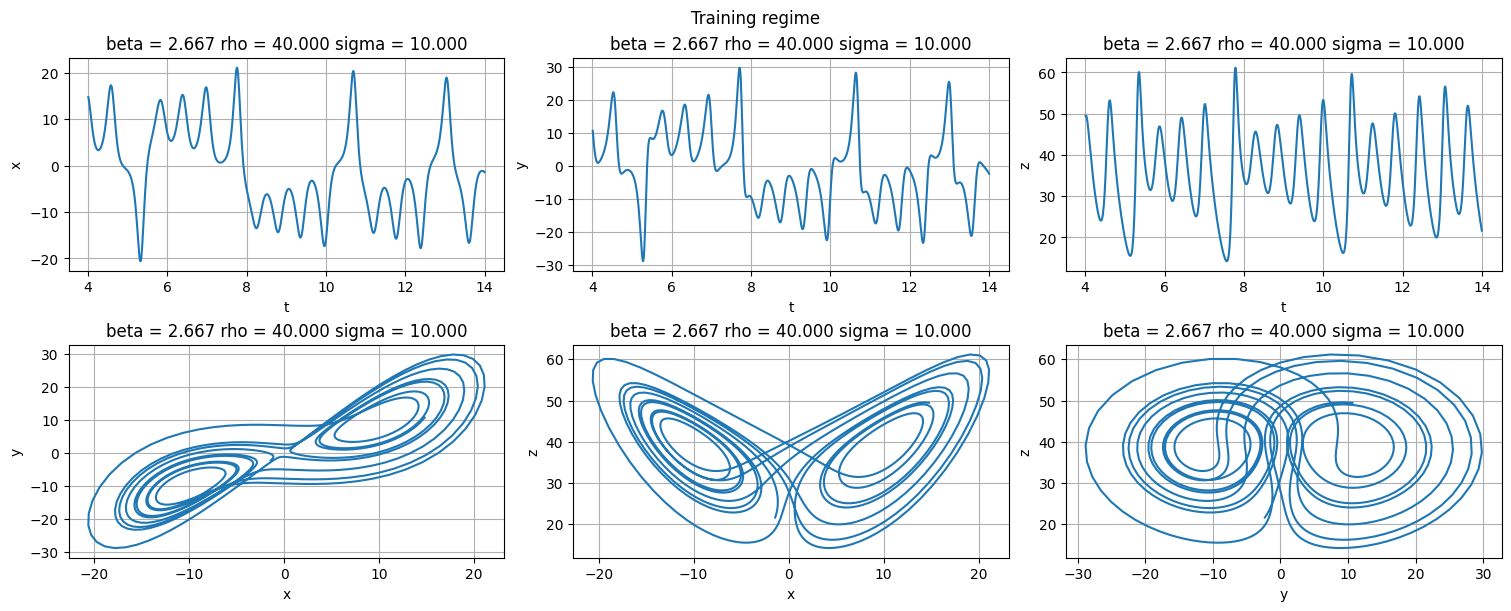

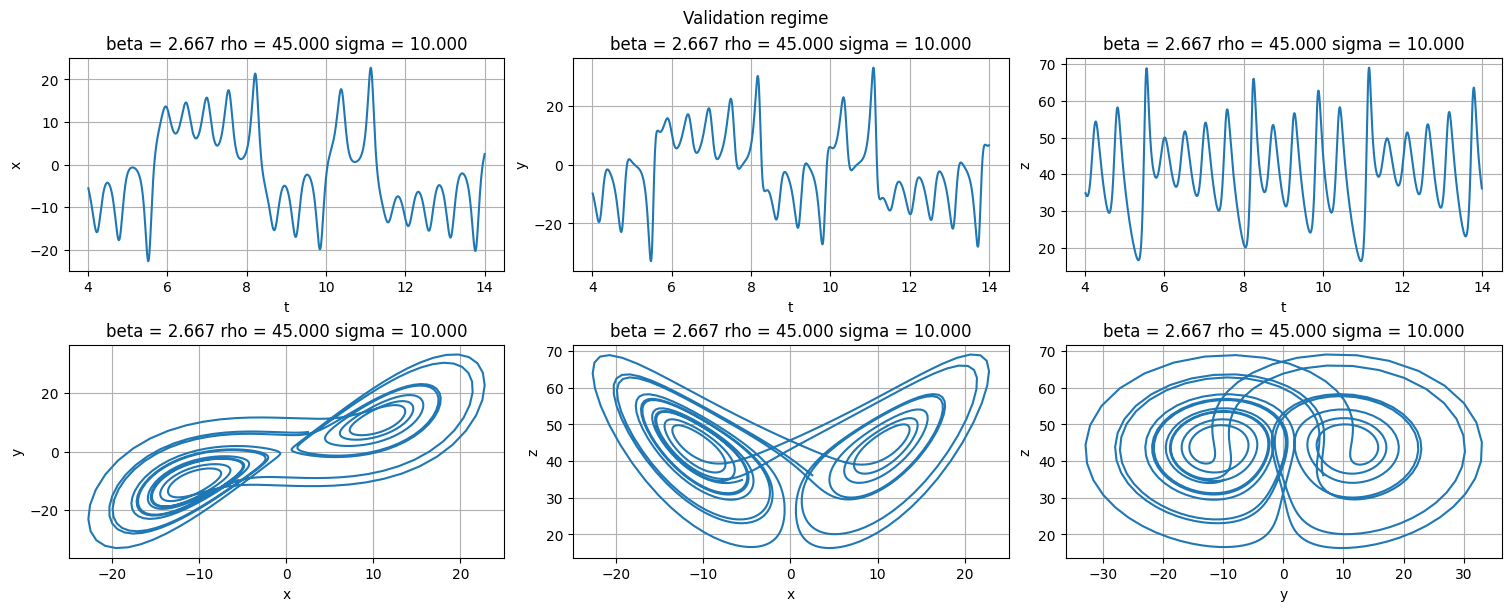

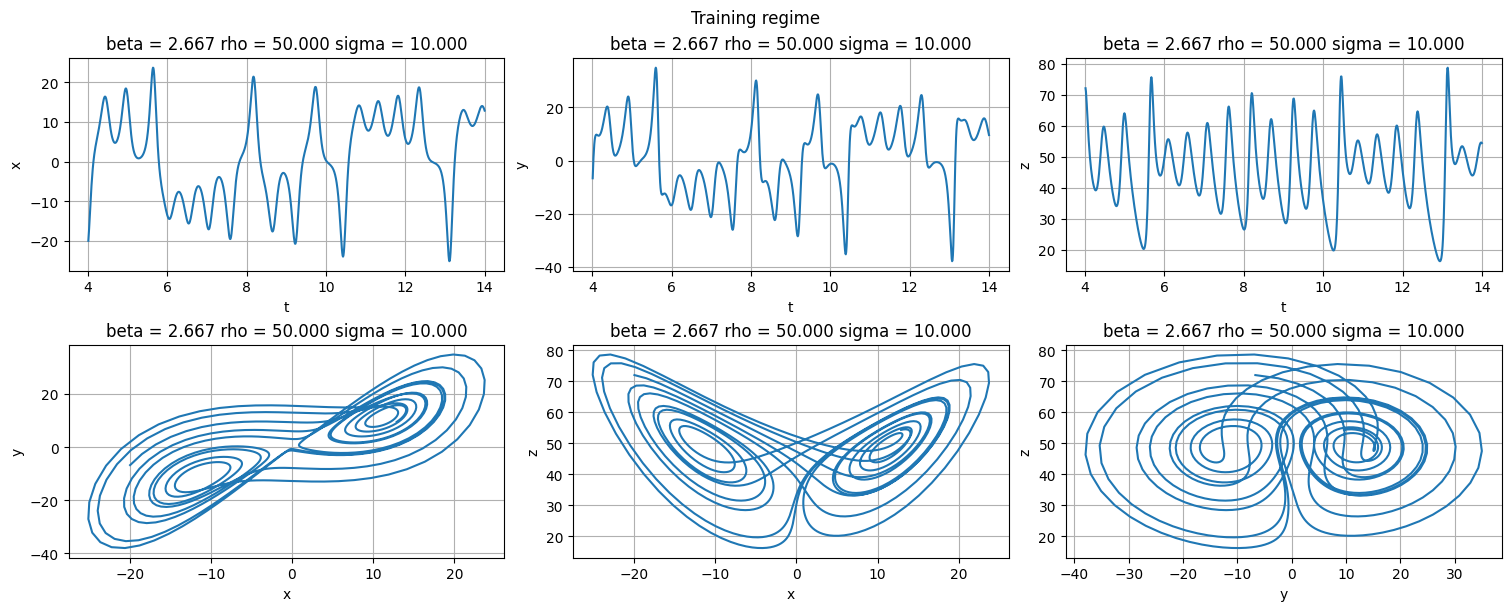

In [4]:
plt_idx = [eSys.x,eSys.y,eSys.z]
plt_idx_pairs = [[eSys.x,eSys.y],
                 [eSys.x,eSys.z],
                 [eSys.y,eSys.z]]
plt_p_idxs = np.random.randint(0,len(param_list)-1,5) # plot only some of the regimes
for p_idx, p in enumerate(param_list):
    plt.figure(figsize = (15,6),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(2,len(plt_idx),j+1)
        title_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in sys.get_eParamVar()])
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=title_str,
                   xlabel='t',
                   ylabel=k.name)
    if p_idx in train_idx_list:
        plt.suptitle('Training regime')
    elif p_idx in val_idx_list:
        plt.suptitle('Validation regime')

    for j, k in enumerate(plt_idx_pairs):
        plt.subplot(2,len(plt_idx),len(plt_idx)+j+1)
        vis.plot_phase_space(DATA["train"]["u"][p_idx],
                            idx_pair=k,
                            title=title_str,
                            xlabel=k[0].name,
                            ylabel=k[1].name)

## Hyperparameter search

In [5]:
# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['input_scaling','spectral_radius','leak_factor','parameter_normalization_mean','parameter_normalization_var','tikhonov']

# range for hyperparameters 
spec_in     = 0.01
spec_end    = 1.0
in_scal_in  = 0.01
in_scal_end = 1.0
leak_in     = 0.01    
leak_end    = 1.0
param_var_in = 0.001
param_var_end = 0.1
param_mean_in = 50.0
param_mean_end = 100.0
tikh_in = 1e-5
tikh_end = 1e-2
grid_range = [[in_scal_in, in_scal_end],
              [spec_in, spec_end],
              [leak_in, leak_end],
              [param_mean_in, param_mean_end],
              [param_var_in, param_var_end],
              [tikh_in, tikh_end]]

# scales, uniform or log10
hyp_param_scales = ['log10','log10','log10','uniform','log10','log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])
        
N_washout = int(np.round(washout_time/network_dt))

# set the time for each fold, i.e., trajectory, in closed-loop validation 
# we validate ESN performance in closed-loop on folds with randomly
# chosen starting points
fold_time = 2 
N_val = int(np.round(fold_time/network_dt))

N_transient = 0

# set attributes of the base ESN object
reservoir_size = 1200
connectivity = 20
ESN_dict = {'reservoir_size': reservoir_size, 
            'dimension' : dim, 
            'parameter_dimension' : len(param_vars),
            'reservoir_connectivity' : connectivity,
            'input_normalization': None, 
            'input_bias' : np.array([]),
            'output_bias' : np.array([]),
            'parameter_normalization': [np.array([0.0]),np.array([1.0])],
            'r2_mode': False,
            'input_weights_mode': "sparse_grouped",
            'reservoir_weights_mode': "erdos_renyi1",
            'input_only_mode': False,
            'tikhonov': 1e-1,
            }

# train and validate on the specified regimes
# using Bayesian optimization scheme
# we find the hyperparameters that give the best validation error 
# over many realisations of the ESN
min_dict = validate(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 20, n_initial_points = 10, # number of hyperparameter sets we try
    ESN_dict = ESN_dict, ESN_type = "standard",
    U_washout_train = DATA["train"]["u_washout"],
    U_train = DATA["train"]["u"],
    U_val = DATA["val"]["u"],
    Y_train = DATA["train"]["y"],
    Y_val = DATA["val"]["y"],
    P_washout_train = DATA["train"]["p_washout"],
    P_train = DATA["train"]["p"],
    P_val = DATA["val"]["p"],
    n_folds=3, # number of folds for validation
    n_realisations=3, # number of different realisations of ESN
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    N_transient_steps = N_transient,
    train_idx_list=train_idx_list,
    val_idx_list=val_idx_list,
    p_list= param_list,
    n_grid = None,
    error_measure=errors.rel_L2)

--NEW RUN-- 1
Realisation: 0
input_scaling 0.03958423933267796
spectral_radius 0.09753935043347353
leak_factor 0.07691833864717756
parameter_normalization_mean 91.59556794856006
parameter_normalization_var 0.014677208842799487
tikhonov 1e-05


Val regime: 0
Val regime error: 0.04911947677454168
Val regime: 1
Val regime error: 0.051425068058403786
Realisation error: 0.05027227241647274


Realisation: 1
input_scaling 0.03958423933267796
spectral_radius 0.09753935043347353
leak_factor 0.07691833864717756
parameter_normalization_mean 91.59556794856006
parameter_normalization_var 0.014677208842799487
tikhonov 1e-05


Val regime: 0
Val regime error: 0.13444653614773444
Val regime: 1
Val regime error: 0.12375083245242953
Realisation error: 0.12909868430008198


Realisation: 2
input_scaling 0.03958423933267796
spectral_radius 0.09753935043347353
leak_factor 0.07691833864717756
parameter_normalization_mean 91.59556794856006
parameter_normalization_var 0.014677208842799487
tikhonov 1e-05


Val r

## Train 

In [6]:
res_idx = 0 # use the hyperparameters of the top result from hyperparameter search
ESN_dict['input_seeds'] = [0,1,2]
ESN_dict['reservoir_seeds'] = [3,4]
my_ESN = ESN(**ESN_dict) # create an ESN object
hyp_params = [min_dict[hyp_param_name][res_idx] for hyp_param_name in hyp_param_names]
hyp_param_scales = ['uniform']*len(hyp_param_names) # hyperparameters are saved in a uniform scale
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

# train the ESN using the found hyperparameters
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Input weights are rescaled with the new input scaling.
Reservoir weights are rescaled with the new spectral radius.
Parameter normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.


## Predict and visualize

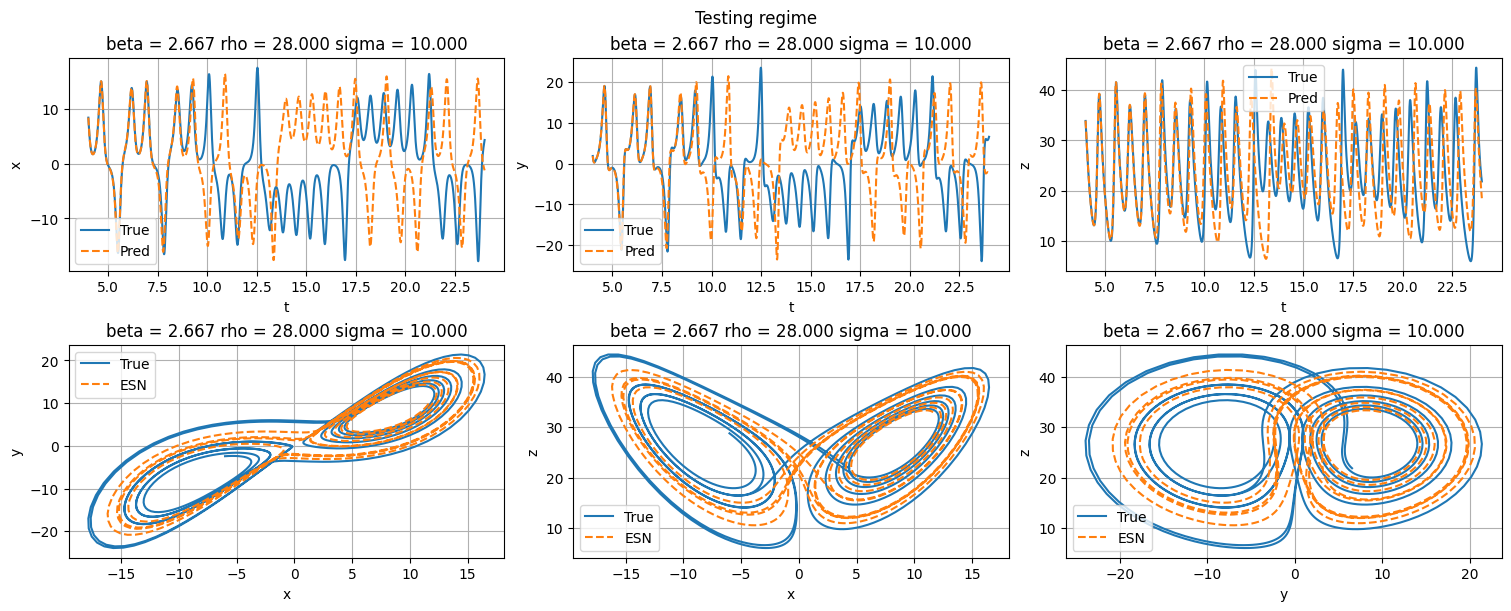

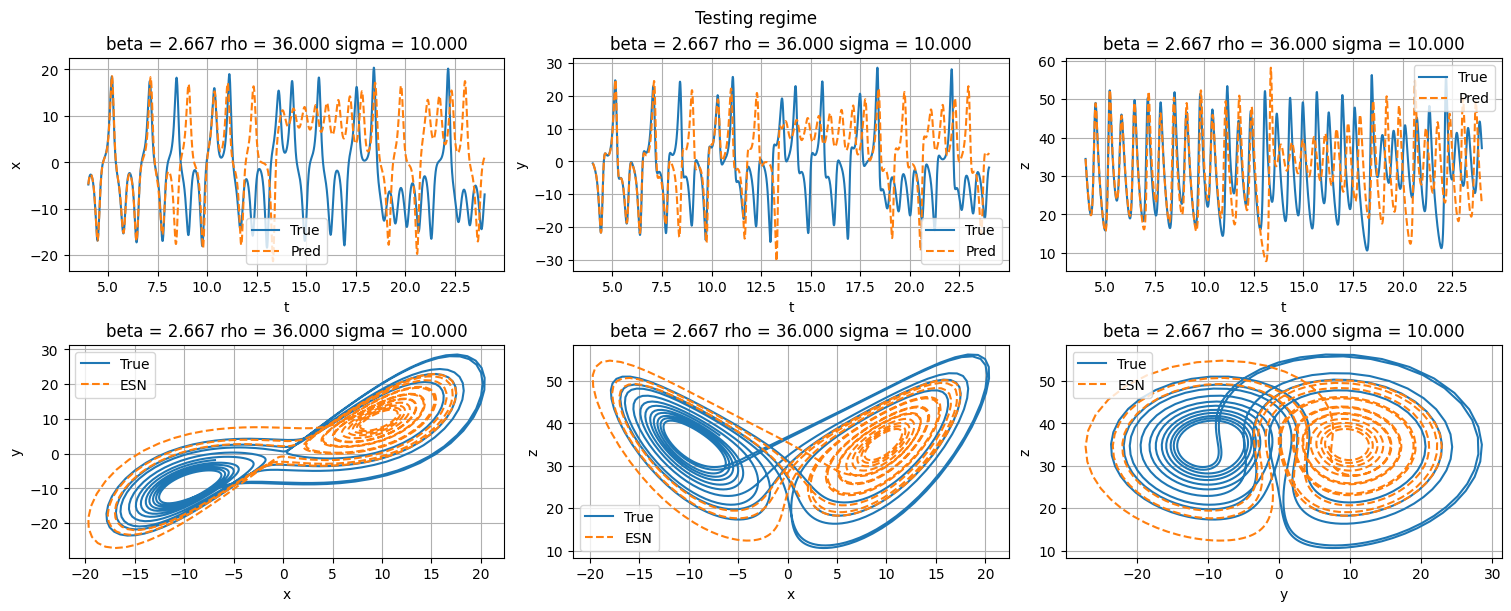

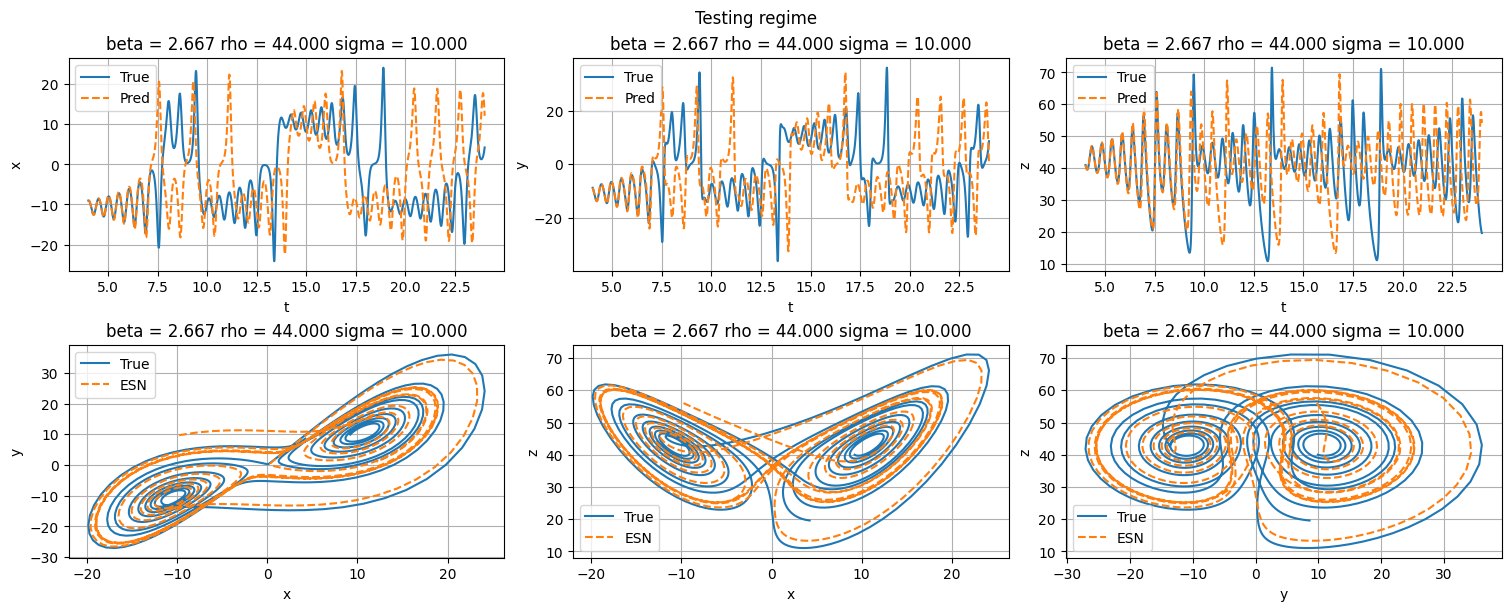

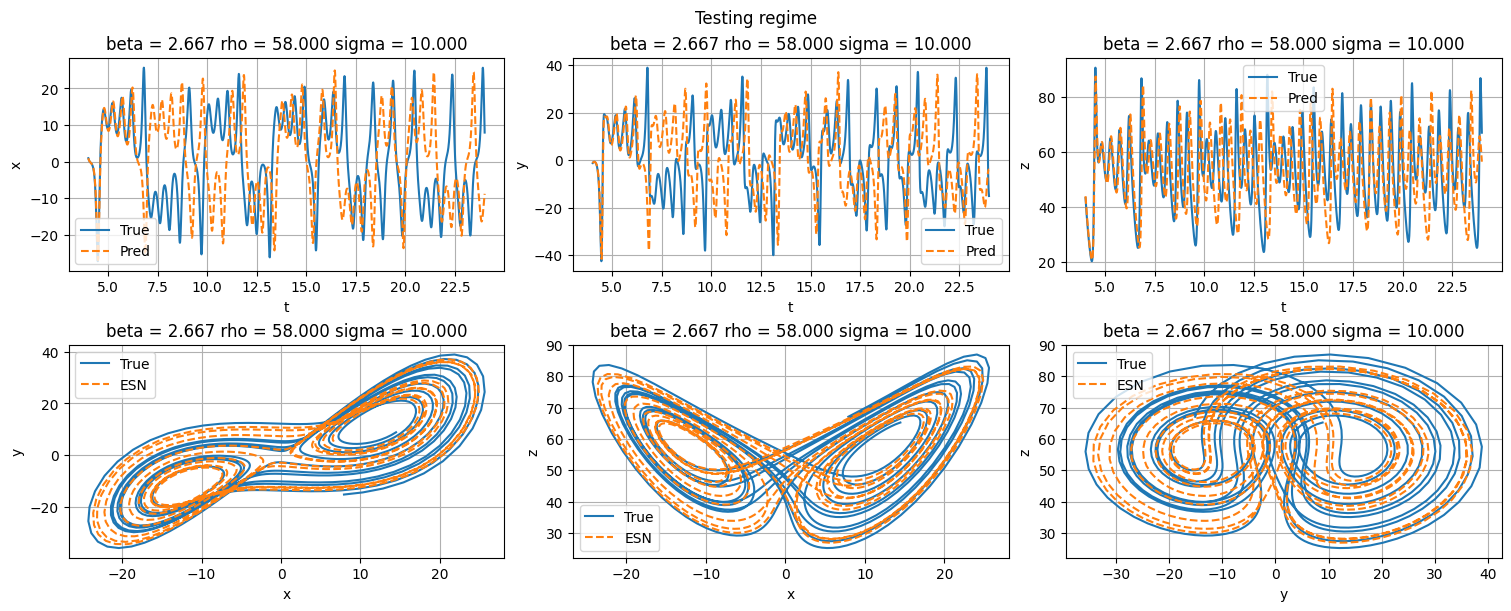

In [7]:
loop_times = [20]
sim_time = transient_time+np.sum(loop_times)+washout_time*len(loop_times)

# predict on some test sets not seen during training or validation
param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = INIT_beta_list
param_mesh_input[eParam.rho] = [28,36,44,58]
param_mesh_input[eParam.sigma] = INIT_sigma_list

p_list = pp.make_param_mesh(param_mesh_input)

plt_idx = [eSys.x,eSys.y,eSys.z]
plt_idx_pairs = [[eSys.x,eSys.y],
                 [eSys.x,eSys.z],
                 [eSys.y,eSys.z]]

phase_space_steps = pp.get_steps(10,network_dt)

for p_idx, p in enumerate(p_list):
    params = {}
    for param in sys.get_eParamVar():
        params[param.name] = p[param]

    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,params,sim_time,sim_dt,random_seed=0,integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=input_vars,
                        param_vars=param_vars,
                        loop_times=loop_times)
    
    for loop_name in data.keys():
        # run trained ESN in closed-loop given the washout data which serves as initial condition
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in sys.get_eParamVar()])
        # plot time series
        plt.figure(figsize = (15,6),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(2,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       linestyle=['-','--'],
                       legend=['True','Pred'],
                       ylabel=k.name)
            
        plt.suptitle('Testing regime')
        # plot phase space  
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(2,len(plt_idx),len(plt_idx)+ j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','ESN'],
                             xlabel=k[0].name,
                             ylabel=k[1].name)

## Statistics

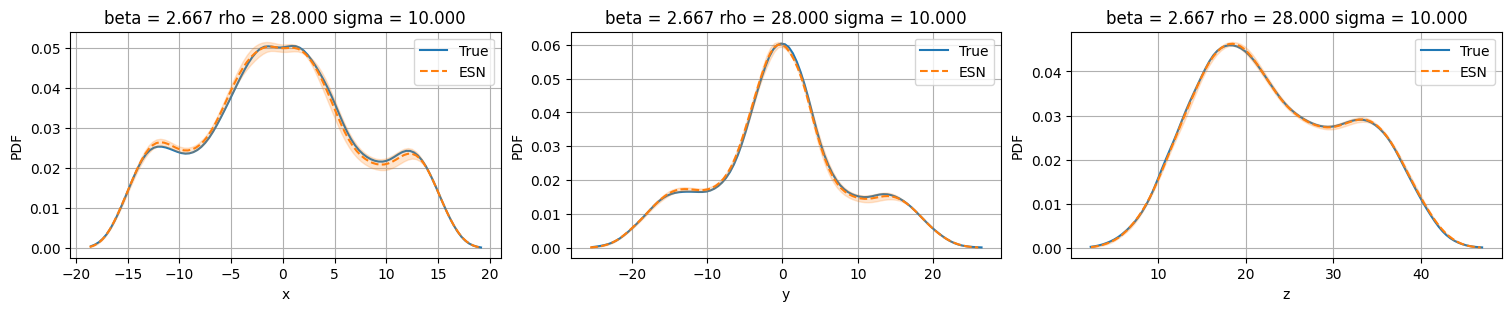

In [8]:
# generate and train ESN realisations
n_ensemble = 5
ESN_list = [None] * n_ensemble
for e_idx in range(n_ensemble):
    # fix the seeds
    input_seeds = [5 * e_idx, 5 * e_idx + 1, 5 * e_idx + 2]
    reservoir_seeds = [5 * e_idx + 3, 5 * e_idx + 4]

    # expand the ESN dict with the fixed seeds
    ESN_dict["input_seeds"] = input_seeds
    ESN_dict["reservoir_seeds"] = reservoir_seeds
    ESN_dict["verbose"] = False
    my_ESN = ESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

    my_ESN.train(DATA["train"]["u_washout"], 
                DATA["train"]["u"], 
                DATA["train"]["y"],
                P_washout=DATA["train"]["p_washout"], 
                P_train=DATA["train"]["p"],
                train_idx_list=train_idx_list)
    ESN_list[e_idx] = my_ESN

params = {"beta": 8/3,
          "rho": 28,
          "sigma": 10.0}

regime_str = ' '.join([f"{param_name} = {params[param_name]:0.3f}" for param_name in params.keys()])

# to compute statistics, we evolve the original system and ESN for long time
# so that the statistics converge
loop_times = [1000]
sim_time = transient_time+np.sum(loop_times)+washout_time*len(loop_times)

my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                            params,
                                            sim_time,
                                            sim_dt,
                                            random_seed=0,
                                            integrator=integrator)

data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=input_vars,
                    param_vars=param_vars,
                    loop_times=loop_times)

Y_PRED = [None] * n_ensemble
for e_idx, my_ESN in enumerate(ESN_list):
    x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["loop_0"]["u_washout"], 
                                                        N_t=len(data["loop_0"]["u"]), 
                                                        P_washout=data["loop_0"]["p_washout"],  
                                                        P=data["loop_0"]["p"])
    y_pred = y_pred[1:]
    Y_PRED[e_idx] = y_pred

plt_idx = [eSys.x,eSys.y,eSys.z]
plt.figure(figsize = (15,3),constrained_layout=True)
for j, k in enumerate(plt_idx):
    plt.subplot(1,len(plt_idx),j+1)
    vis.plot_statistics_ensemble(*[Y_PRED[e][:, k] for e in range(n_ensemble)],
                        y_base=data["loop_0"]["y"][:,k],
                        title=regime_str,
                        ylabel='PDF',
                        xlabel=k.name,
                        linestyle=['-','--'],
                        legend=['True','ESN'],
                        color=["tab:blue","tab:orange"])

## Sensitivity

In [10]:
def objective_fun(u):
    obj = np.mean(u[:,eSys.z]) # our objective is the z variable
    return  obj 

def dobjective_fun(u):
    dobj = np.zeros(3)
    dobj[eSys.z] = 1
    return dobj

params = {"beta": 8/3,
          "rho": 28,
          "sigma": 10}

loop_times = [0.55] * 5 # 0.5 Lyapunov time
sim_time = transient_time+np.sum(loop_times)+washout_time*len(loop_times)

# load system data to get a trajectory
my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0,integrator=integrator)

# first we generate the direct solution for sensitivity
data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=input_vars,
                    param_vars=param_vars,
                    loop_times=loop_times)

for loop_name in data.keys():
    print(f'Loop {loop_name[-1]}')
    t_bar = data[loop_name]["t"]-data[loop_name]["t"][0]
    y_bar = data[loop_name]["u"]

    # calculate sensitivity of the true system

    # using tangent linear method
    dJdp_dir = sens.true_direct_sensitivity(my_sys, t_bar, y_bar, dobjective_fun)

    # using adjoint method
    dJdp_adj = sens.true_adjoint_sensitivity(my_sys, t_bar, y_bar, dobjective_fun)
    
    # using finite differences
    dJdp_finite = sens.true_finite_difference_sensitivity(
        my_sys, t_bar, y_bar, h=1e-8, objective_fun=objective_fun, method="central")

    # first we generate the direct solution for sensitivity
    # run ESN in closed-loop to get a trajectory
    x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                N_t=len(data[loop_name]["u"]), 
                                                P_washout=data[loop_name]["p_washout"],  
                                                P=data[loop_name]["p"])

    N = len(data[loop_name]["u"])
    # calculate sensitivity of the ESN
    # using tangent linear method
    dJdp_esn_dir = my_ESN.direct_sensitivity(x_pred, y_pred, N, dJdy_fun=dobjective_fun)

    # using adjoint method
    dJdp_esn_adj = my_ESN.adjoint_sensitivity(x_pred, y_pred, N, dJdy_fun=dobjective_fun)

    # using finite differences                  
    dJdp_esn_finite = my_ESN.finite_difference_sensitivity(X=x_pred, 
                                                        Y=y_pred,  
                                                        P=data[loop_name]["p"], 
                                                        N=N, 
                                                        method="central",
                                                        J_fun=objective_fun)
    i = 0
    for param in eParam:
        print_str_dir = f'Tangent linear dJ/d{param.name} true: {dJdp_dir[param]}'
        print_str_adj = f'Adjoint dJ/d{param.name} true: {dJdp_adj[param]}'
        print_str_fin = f'Finite difference dJ/d{param.name} true: {dJdp_finite[param]}'
        if param.name in param_vars:
            print_str_dir = print_str_dir + f', dJ/d{param.name} esn: {dJdp_esn_dir[i]}'
            print_str_adj = print_str_adj + f', dJ/d{param.name} esn: {dJdp_esn_adj[i]}'
            print_str_fin = print_str_fin + f', dJ/d{param.name} esn: {dJdp_esn_finite[i]}'
            i+=1
        print(print_str_dir)
        print(print_str_adj)
        print(print_str_fin)

Loop 0
Adjoint dJ/dbeta true: -0.8083011522325368
Adjoint dJ/drho true: 1.3805082035436742, dJ/drho esn: 1.6908432289566329
Adjoint dJ/dsigma true: -0.1272565621857314
Loop 1
Adjoint dJ/dbeta true: -0.7551351564297044
Adjoint dJ/drho true: 1.2894357769803086, dJ/drho esn: 1.5025332297353617
Adjoint dJ/dsigma true: 0.0069292292902614116
Loop 2
Adjoint dJ/dbeta true: -0.6585718239849745
Adjoint dJ/drho true: 0.9891278167881771, dJ/drho esn: 1.0094269616963085
Adjoint dJ/dsigma true: -0.03866200001447892
Loop 3
Adjoint dJ/dbeta true: 0.9665163730414977
Adjoint dJ/drho true: 1.6207334512538547, dJ/drho esn: 1.9567524051838432
Adjoint dJ/dsigma true: 0.040726782876554936
Loop 4
Adjoint dJ/dbeta true: -0.24933534610645094
Adjoint dJ/drho true: 1.1441946496929059, dJ/drho esn: 1.1590808017129608
Adjoint dJ/dsigma true: 0.2839528864466092
